# Fake News Detection Using Machine Learning

### Step 1: Load and Inspect Dataset

In [2]:
import pandas as pd

# Load dataset
file_path = "final_fake_news_predictions.csv"  # Make sure this matches your filename
df = pd.read_csv(file_path)

In [3]:
# Inspect the dataset
print("Dataset shape:", df.shape)
print("Columns:", df.columns)
df.head()

Dataset shape: (1267, 4)
Columns: Index(['text', 'cleaned_text', 'label', 'predicted_label'], dtype='object')


,text,cleaned_text,label,predicted_label
0,Will Trump pull a Brexit times ten? What would...,trump pull brexit times ten would take beyond ...,FAKE,FAKE
1,Clintons Are Under Multiple FBI Investigations...,clintons multiple fbi investigations agents st...,FAKE,FAKE
2,Dispatches from Eric Zuesse This piece is cros...,dispatches eric zuesse piece crossposted strat...,FAKE,FAKE
3,Print \n[Ed. – Every now and then the facade c...,print ed every facade cracks somebody asks que...,FAKE,FAKE
4,Nanny In Jail After Force Feeding Baby To Deat...,nanny jail force feeding baby death 2 shares i...,FAKE,FAKE


### Step 2: Data Cleaning + Preprocessing

In [4]:
import re
import string

# Fill missing cleaned_text using original text
df['cleaned_text'] = df['cleaned_text'].fillna(df['text'])

# Label encoding: FAKE → 0, REAL → 1
df['label_encoded'] = df['label'].map({'FAKE': 0, 'REAL': 1})

# Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Clean the content
df['cleaned_text'] = df['cleaned_text'].astype(str).apply(clean_text)

# Check result
df[['cleaned_text', 'label_encoded']].head()


,cleaned_text,label_encoded
0,trump pull brexit times ten would take beyond ...,0
1,clintons multiple fbi investigations agents st...,0
2,dispatches eric zuesse piece crossposted strat...,0
3,print ed every facade cracks somebody asks que...,0
4,nanny jail force feeding baby death shares ik...,0


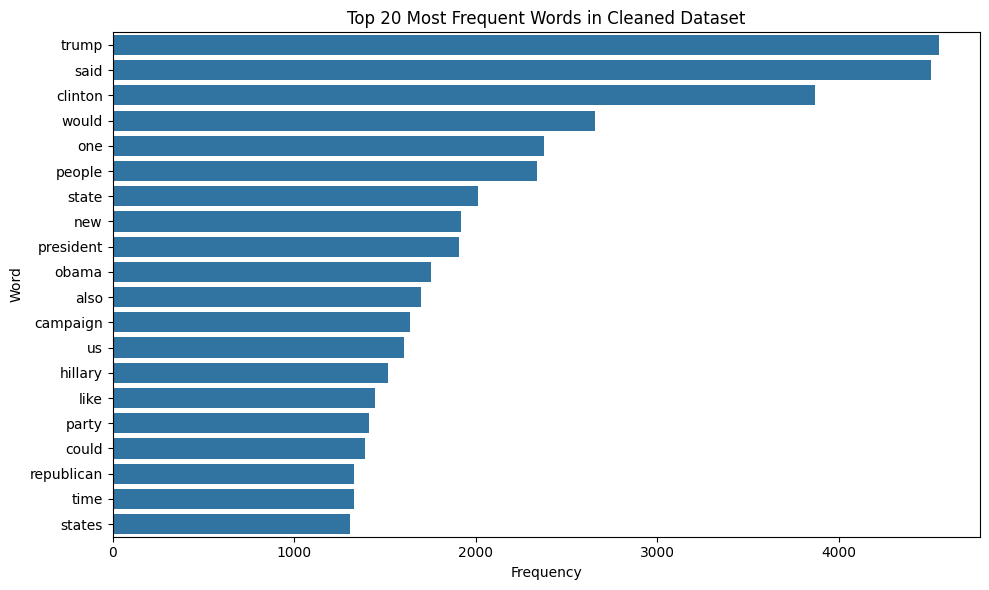

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Split and count word frequencies
all_words = " ".join(df['cleaned_text']).split()
common_words = Counter(all_words).most_common(20)

# Plot top 20 words
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Most Frequent Words in Cleaned Dataset")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


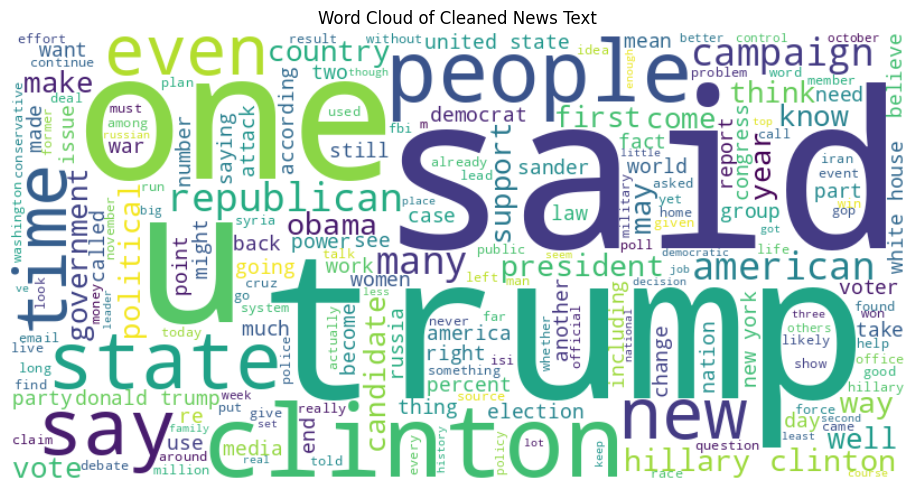

In [6]:
from wordcloud import WordCloud

text = " ".join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned News Text")
plt.tight_layout()
plt.show()


###Step 3: Feature Extraction (TF-IDF with bigrams)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF vectorization with unigrams + bigrams
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1, 2),max_features=5000)

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label_encoded']

###Step 4: Train-Test Split

In [8]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Confirm shapes
X_train.shape, X_test.shape

((1013, 5000), (254, 5000))

### Step 5: Train Models (Logistic Regression, Naive Bayes, Decision Tree, Random Forest, SVM, XGBoost)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dictionary to store results
results = {}

# Helper function to evaluate models
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    }

    print(f"\n=== {name} ===")
    for metric, value in results[name].items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

Logistic Regression

In [10]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
evaluate_model("Logistic Regression", lr, X_test, y_test)


=== Logistic Regression ===
Accuracy: 0.9134
Precision: 0.9569
Recall: 0.8672
F1 Score: 0.9098
ROC AUC: 0.9784


Naive Bayes

In [11]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
evaluate_model("Naive Bayes", nb, X_test, y_test)


=== Naive Bayes ===
Accuracy: 0.8976
Precision: 0.9250
Recall: 0.8672
F1 Score: 0.8952
ROC AUC: 0.9643


Decision Tree

In [12]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
evaluate_model("Decision Tree", dt, X_test, y_test)


=== Decision Tree ===
Accuracy: 0.7559
Precision: 0.7661
Recall: 0.7422
F1 Score: 0.7540
ROC AUC: 0.7560


Random Forest

In [13]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model("Random Forest", rf, X_test, y_test)


=== Random Forest ===
Accuracy: 0.9055
Precision: 0.9194
Recall: 0.8906
F1 Score: 0.9048
ROC AUC: 0.9615


Support Vector Machine

In [14]:
# Support Vector Machine
svm = SVC(probability=True)
svm.fit(X_train, y_train)
evaluate_model("SVM", svm, X_test, y_test)


=== SVM ===
Accuracy: 0.9134
Precision: 0.9649
Recall: 0.8594
F1 Score: 0.9091
ROC AUC: 0.9814


XGBoost

In [15]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
evaluate_model("XGBoost", xgb, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:57:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
Accuracy: 0.9016
Precision: 0.9120
Recall: 0.8906
F1 Score: 0.9012
ROC AUC: 0.9568


### Step 6: Evaluate Models

In [16]:
import pandas as pd

results_df = pd.DataFrame(results).T.sort_values(by='F1 Score', ascending=False)
results_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.913386,0.956897,0.867188,0.909836,0.978423
SVM,0.913386,0.964912,0.859375,0.909091,0.981430
Random Forest,0.905512,0.919355,0.890625,0.904762,0.961527
XGBoost,0.901575,0.912000,0.890625,0.901186,0.956783
Naive Bayes,0.897638,0.925000,0.867188,0.895161,0.964286
Decision Tree,0.755906,0.766129,0.742188,0.753968,0.756014


### Step 7: Visualizations

WordCloud

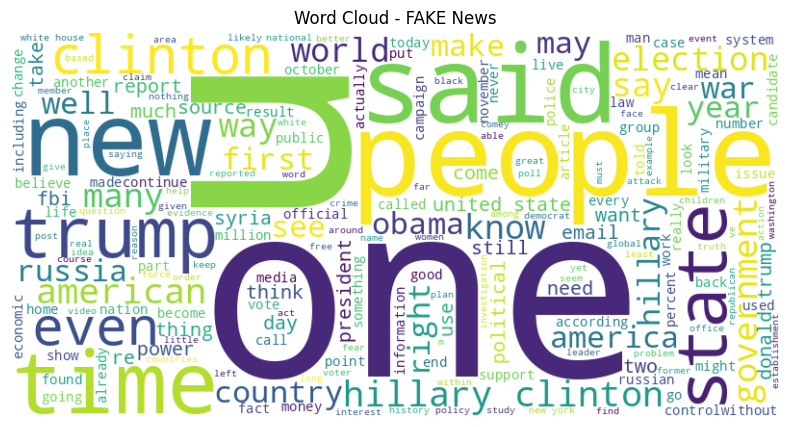

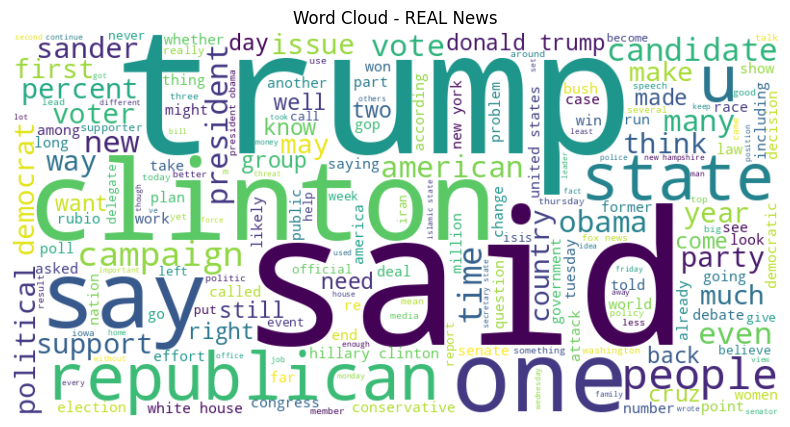

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate texts
fake_text = " ".join(df[df['label_encoded'] == 0]['cleaned_text'])
real_text = " ".join(df[df['label_encoded'] == 1]['cleaned_text'])

# WordCloud for FAKE news
fake_wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.figure(figsize=(10, 5))
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - FAKE News")
plt.show()

# WordCloud for REAL news
real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.figure(figsize=(10, 5))
plt.imshow(real_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - REAL News")
plt.show()


Confusion Matrix

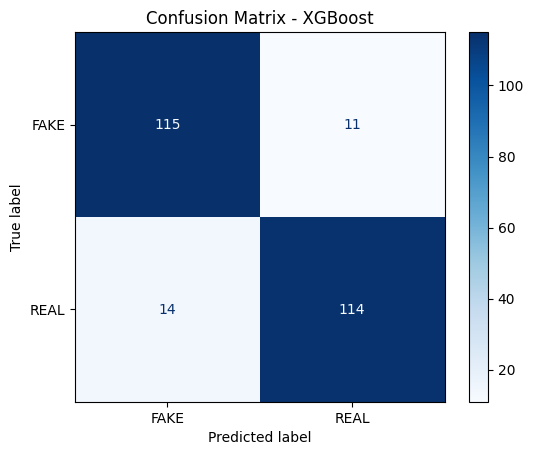

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"]).plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()


ROC Curve

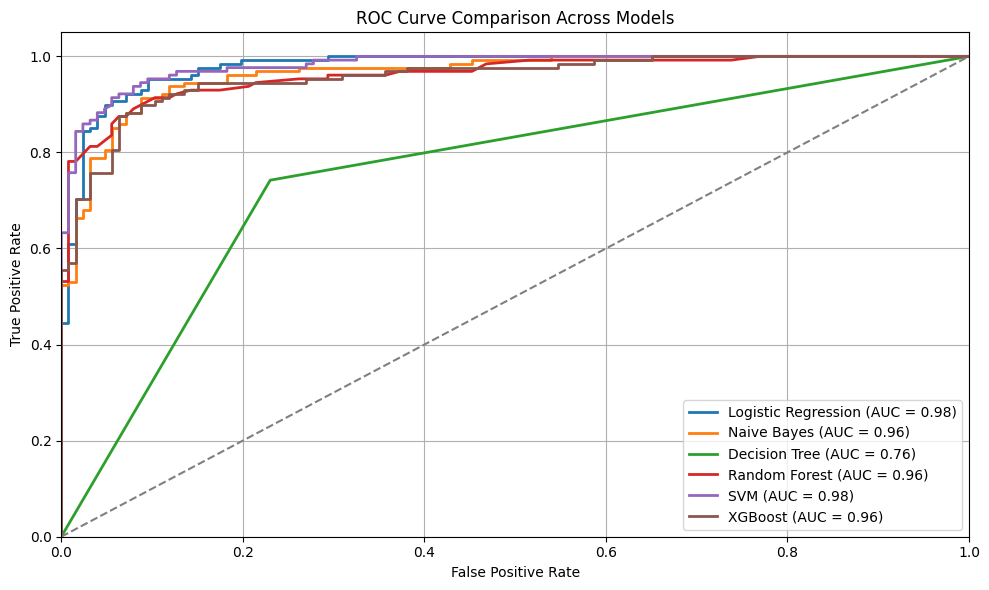

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the models dictionary here with model names and instances
models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "Decision Tree": dt,
    "Random Forest": rf,
    "SVM": svm,
    "XGBoost": xgb
}

# Plot ROC curves for all trained models
plt.figure(figsize=(10, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        continue  # Skip models without probability outputs

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Heatmap of Model Performance

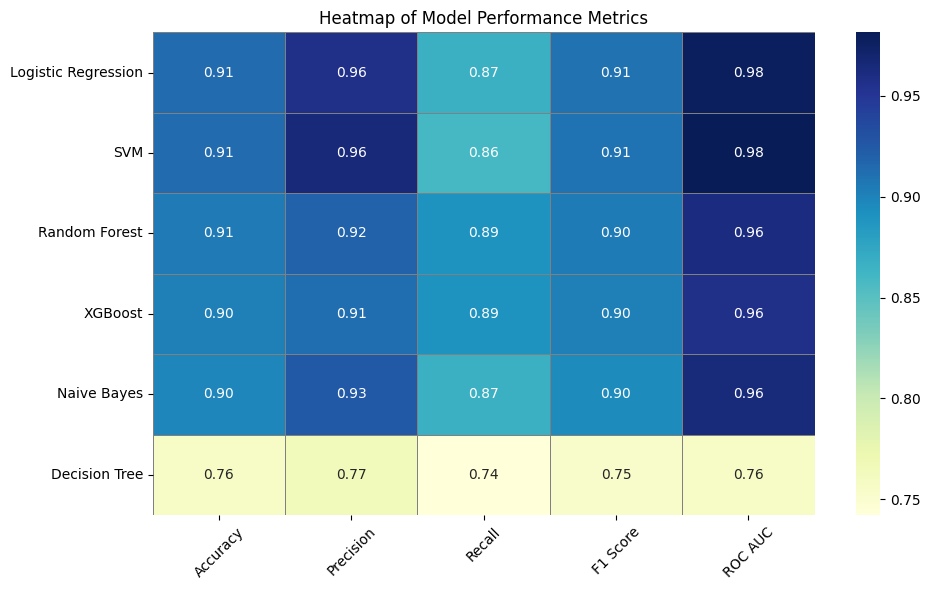

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure all values are numeric (ignore 'N/A' if present)
heatmap_df = results_df.replace("N/A", np.nan).astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title("Heatmap of Model Performance Metrics")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


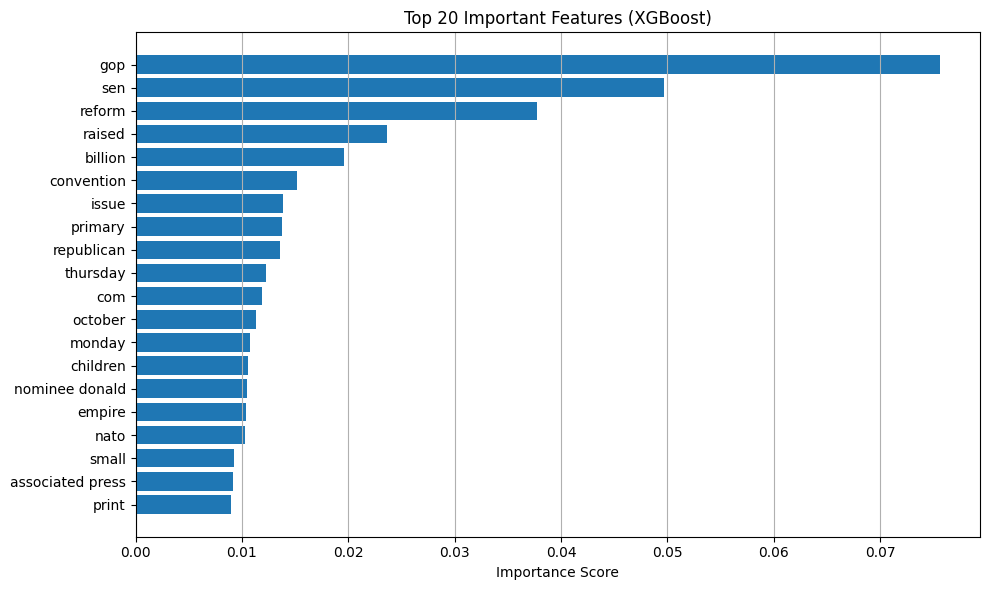

In [21]:
import numpy as np

importances = xgb.feature_importances_
indices = np.argsort(importances)[-20:]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 20 Important Features (XGBoost)')
plt.tight_layout()
plt.grid(axis='x')
plt.show()


Model Performance Comparison

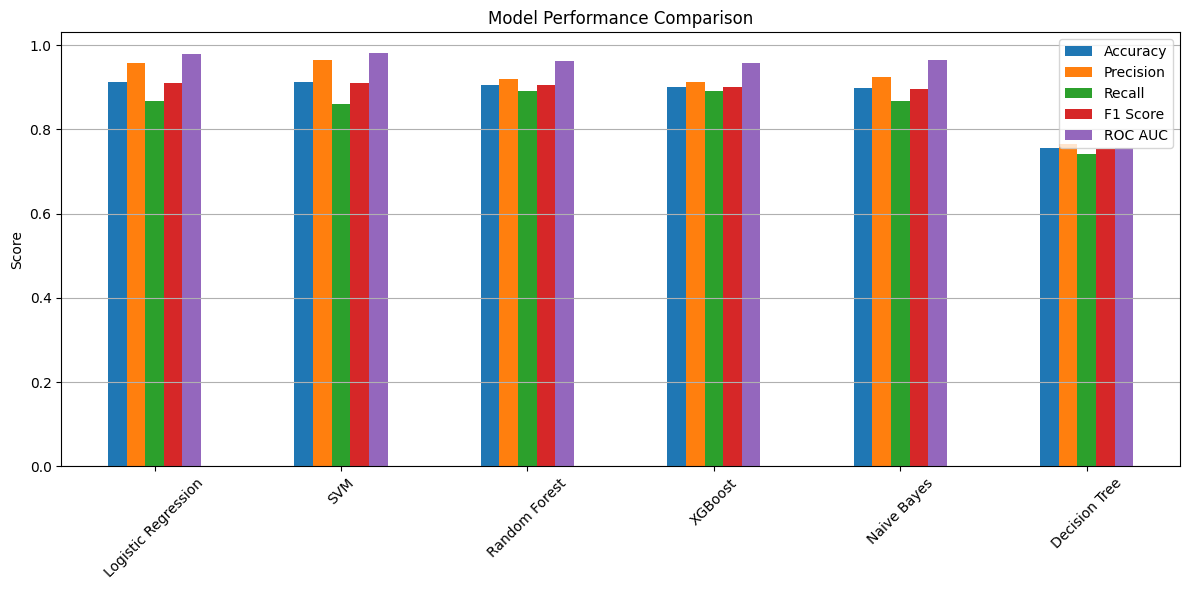

In [22]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()